# Trabajo Práctico 5 - Visión por Computadora I

## Detector de Fondo Naive

### Alumno: Domenje Carlos



### ✒️ Enunciado

▪ Implementar el detector de fondo naive usando la mediana como estimador. El algoritmo debe recibir el parámetro N (cantidad de frames utilizados para la estimación) y el intervalo de tiempo para recalcular el fondo.

▪ Se deben generar las mascaras de foreground y aplicarlas a los frames para segmentar los objetos en movimiento.

▪ Comparar con alguno de los métodos vistos en la practica basados en mezcla de gaussianas

### 💾 Imports de librerias necesarias 


In [1]:

import warnings
warnings.filterwarnings("ignore")
# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

from time import time
import os

### 📟 Sustraccion de Fondo Naive

Guiandome por la teoria vista en clases, tenemos que el algoritmo debe cumplir o realizar los siguientes pasos:

Naive background substraction: La mediana como estimador

- Se eligen N frames aleatorios y se calcula la mediana (background).

- Se resta el frame actual con la mediana y se binariza para obtener la mascara del objeto (foreground)

- Cada cierto intervalo se actualiza el modelo de background recalculando la mediana.

In [2]:
# Filtro de Mediana
# Ingresamos el video al que queremos extraer el fondo y la cantidad de frames que queremos tomar.
# Luego de las pruebas, necesito una variable adicional para no volver a comenzar a filtrar todo los 
# frames desde el comienzo.
def medianFilter(input_video, N=25, frames_to_process=0):  
    frames_process=0
    if frames_to_process == 0:
        frames_process = input_video.get(cv.CAP_PROP_FRAME_COUNT)
    else:
        frames_process = frames_to_process
    randomFrames= (frames_process * np.random.uniform(size=N)).astype(int)
    frames = []
    for frame in randomFrames:
        # Setea el frame
        input_video.set(cv.CAP_PROP_POS_FRAMES, frame)
        # Leemos el frame y hacemos el append al array.
        ret, fr = input_video.read()
      
        frames.append(fr)
        
    # Tengo que dejar el video en el momento en el que estaba cuando se llama a la funcion
    input_video.set(cv.CAP_PROP_POS_FRAMES, frames_to_process)
    # Calculamos la mediana a traves de todo el tiempo.

    mFrame = np.median(frames, axis=0).astype(np.uint8)  
    return mFrame     

In [3]:
filename = './data/autopista.mp4'
capture = cv.VideoCapture(filename)
testImg = capture.get(cv.CAP_PROP_FRAME_COUNT)
if not capture.isOpened:
    print('No se pudo abrir el archivo ')
    exit(0)
median_filter = medianFilter(capture, 60)

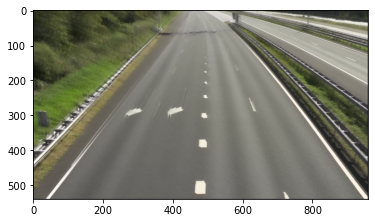

In [4]:
img_filtered = cv.cvtColor(median_filter, cv.COLOR_BGR2RGB)
plt.imshow(img_filtered)
plt.show()   

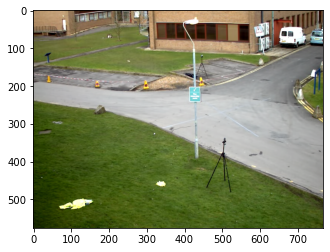

In [5]:
# Test con el video visto en clases
filename = './data/personas.avi'
capture = cv.VideoCapture(filename)
testImg = capture.get(cv.CAP_PROP_FRAME_COUNT)
if not capture.isOpened:
    print('No se pudo abrir el archivo ')
    exit(0)
median_filter = medianFilter(capture, 60)
img_filtered = cv.cvtColor(median_filter, cv.COLOR_BGR2RGB)
plt.imshow(img_filtered)
plt.show()  

#### 🌌 Implementación de Sustraccion de Fondo


In [6]:
def background_subs(input_video, N=10, frames_to_recalculate= 100):
    # Creo las instancias de los diferentes filtros a aplicar y comparar
    backgroundSubMOG2 = cv.createBackgroundSubtractorMOG2()
    backroundSubKNN = cv.createBackgroundSubtractorKNN(detectShadows = True)
    backgroundMedianFilter = medianFilter(input_video,N,0)
    # Dimensiones de la imagen del filtro de mediana para utilizarlo en la ubicacion de pantallas
    heigth,width = backgroundMedianFilter.shape[:-1]
    
    # Inicializacion de variables para el calculo de tiempos de procesamiento entre frames y total
    total_time = 0
    time_between_frame = 0
    total_time_mog2 = 0
    time_between_frame_mog2 = 0
    time_between_frame_KNN = 0
    total_time_KNN = 0
    
    
    while True:
        # Realizo la lectura del frame
        ret, frame = input_video.read()
       
        if frame is None:
            break

        actual_frame = input_video.get(cv.CAP_PROP_POS_FRAMES)      
        # Se recalculan los frames si se llega al parametro indicado en la funcion
        if frames_to_recalculate != 0:
            if actual_frame % frames_to_recalculate == 0:
                backgroundMedianFilter = medianFilter(input_video,N, actual_frame)
        # Obtengo el tiempo actual en el cual se muestra el frame
        actual_time = time()
        
        
        # A cada frame vamos a aplicarle el filtro de mediana
        filter_img = cv.absdiff(frame, backgroundMedianFilter)
        
        #Pasamos la imagen a grises
        filter_img_gray = cv.cvtColor(filter_img, cv.COLOR_BGR2GRAY)
        
        #  Aplicamos Filtro Gaussiano para eliminar ruido utilizando lo visto en practica
        gauss_filter = cv.GaussianBlur(filter_img_gray,(5,5),0)
        thre,mask = cv.threshold(gauss_filter,0,255,cv.THRESH_OTSU)
        kernel = np.ones((3,3),np.uint8)
        open_mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2)
        gaussian_mask = cv.morphologyEx(open_mask, cv.MORPH_CLOSE, kernel, iterations = 2)
        # Calulo del tiempo que tarda en realizar la aplicacion del filtro de mediana.
        time_between_frame = time() - actual_time
        total_time += time_between_frame
        
        # Realizo los calculos para MOG2
        actual_time = time()
        filterMOG2 = backgroundSubMOG2.apply(frame)
        time_between_frame_mog2 = time() - actual_time
        total_time_mog2 += time_between_frame_mog2
        
        # Realizo los calculos para KNN
        actual_time = time()
        filterKNN = backroundSubKNN.apply(frame)
        time_between_frame_KNN = time() - actual_time
        total_time_KNN += time_between_frame_KNN        
        
        # Escribimos sobre la imagen original el número de frame procesado
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(actual_frame), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

        # Escribimos sobre la mascara el frame procesado
        cv.rectangle(gaussian_mask, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(gaussian_mask, str(actual_frame), (15, 15),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))  
        
        # Visualizacion de los resultados obtenidos en 4 videos 
        cv.namedWindow('Original')
        cv.moveWindow('Orignal',0,0)
        cv.imshow('Original', frame)
        
        
        cv.namedWindow('Median Filter')
        cv.moveWindow('Median Filter',0,int(heigth *0.8))
        cv.imshow('Median Filter', gaussian_mask)
        

        cv.namedWindow('MOG2')
        cv.moveWindow('MOG2', width,0)
        cv.imshow('MOG2', filterMOG2)
       
        
        cv.namedWindow('KNN')
        cv.moveWindow('KNN', width,int(heigth*0.8))
        cv.imshow('KNN', filterKNN)
     
        # Corresmos hasta que termine o apriete escape
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
        

    cv.destroyAllWindows()
    input_video.release()
    print(f"Tiempo total aplicando Mediana: {total_time:.3f} \n")
    print(f"Tiempo total aplicando MOG2: {total_time_mog2:.3f} \n")
    print(f"Tiempo total aplicando KNN: {total_time_KNN:.3f}")
 

In [7]:
## Prueba con video de la catedra de personas.

# filename = 'data/personas.avi'
# video = cv.VideoCapture(filename)
# background_subs(video,10,20)

In [8]:
## Prueba con video obtenindo de internet de autos en una autopista.
filename = 'data/autopista.mp4'
video = cv.VideoCapture(filename)
background_subs(video,25,50)

Tiempo total aplicando Mediana: 0.429 

Tiempo total aplicando MOG2: 1.004 

Tiempo total aplicando KNN: 1.483


### 📊 Conclusión

Se realizó la función de estimador de mediana para aplicarlo al detector de fondo donde se pudo probar con dos videos diferentes. En cualquiera de los casos se obtuvieron resultados positivos.

Luego, se realizó el algoritmo para poder aplicar la mascara a cada frame y asi filtrar los objetos que se estan moviendo continuamente. Para el caso de las personas se obtuvo mejores resultados que para la autopista y esto puede ser debido a que en el video de autopista podemos notar pequeños movimientos en los arboles, lo que genera tambien cierto ruido a la hora de aplicar el filtro. Mas alla de esto, se pudo lograr el objetivo de implementar y observar el funcionamiento de sustraccion de fondo.

Por ultimo, se imprimen los resultados de los tiempos estimados de cada filtro obteniendo que el filtro de mediana tiene mayor rapidez en su aplicacion. 

Un aspecto negativo que se vio, es que al requerir en X frame un recalculo del filtro, se nota como este realentiza el video y no deja un apecto visual positivo y por otro lado no se notan grandes diferencias en hacerlo.